In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from mpl_toolkits.mplot3d import Axes3D

##### Exercise 11.3

In [2]:
# Superparameters
# (Common parameters for all models)
n_epochs = 25
n_training_data = 1000
n_validation_data = 100
x_min, x_max = -3/2, 3/2
y_min, y_max = -3/2, 3/2
noise = 0.2
np.random.seed(0)

def target_fn(x):
    return np.sin(x[0]**2 + x[1]**2)

def create_grid(n_points_side):
    r = np.array([
        np.random.uniform(x_min, x_max, n_points_side),
        np.random.uniform(y_min, y_max, n_points_side)
    ])
    return r.T

In [3]:
# Generate training inputs, drawing points uniformly
# from the [x_min ,x_max] * [y_min, y_max] square.
in_training   = create_grid(n_training_data)
in_validation = create_grid(n_validation_data)

out_training   = np.random.normal([target_fn(x) for x in in_training], noise)
out_validation = np.random.normal([target_fn(x) for x in in_validation], noise)

in_target  = in_validation
out_target = target_fn(in_target)

In [4]:
class neural_network:
    def __init__(self, layers, optimizer_fn, loss_fn):
        self.optimizer_fn = optimizer_fn
        self.loss_fn = loss_fn
        self.network = Sequential()
        self.layers_size = [item[0] for item in layers]
        self.activation_functions = [item[1] for item in layers]

###### Definition of the neural networks

In [5]:
'''
I will re-use the multiple-feature scheme I needed in exercise 11.2
to create a ot of networks with different characteristics; however,
since I do not how to use 3D plots and the fig.subplots() syntax
below together, that allowed me to create many plots, one for each
different network in a singe loop, I will create just one model.
'''
features = [
    ([(2, "tanh"), (4, "tanh"), (1, "linear")], "sgd", "mse"),
]
models = [neural_network(layers, optimizer_fn, loss_fn) for layers, optimizer_fn, loss_fn in features]
for model in models:
    for n in range(len(model.layers_size)):
        if n == 0:
            model.network.add(Dense(
                model.layers_size[n],
                input_shape = (2,),
                activation = model.activation_functions[n]
            ))
        else:
            model.network.add(Dense(
                model.layers_size[n],
                activation = model.activation_functions[n]
            ))

###### Training

In [6]:
model_histories = []
for model in models:
    # Compile the model choosing the optimizer, loss and metrics objects.
    model.network.compile(optimizer = model.optimizer_fn, loss = model.loss_fn, metrics = ["mse"])

    # Evaluate the model using the "training" dataset,
    # over epochs of 32 batch size each.
    model_histories.append(model.network.fit(
        x = in_training,
        y = out_training,
        batch_size = 32,
        epochs = n_epochs,
        shuffle = True, # It is a good idea to shuffle the input before each epoch.
        validation_data = (in_validation, out_validation)
    ))

Train on 1000 samples, validate on 100 samples
Epoch 1/25
1000/1000 [==============================] - 0s 336us/step - loss: 0.3829 - mean_squared_error: 0.3829 - val_loss: 0.2521 - val_mean_squared_error: 0.2521
Epoch 2/25
1000/1000 [==============================] - 0s 16us/step - loss: 0.2159 - mean_squared_error: 0.2159 - val_loss: 0.2226 - val_mean_squared_error: 0.2226
Epoch 3/25
1000/1000 [==============================] - 0s 16us/step - loss: 0.1956 - mean_squared_error: 0.1956 - val_loss: 0.2205 - val_mean_squared_error: 0.2205
Epoch 4/25
1000/1000 [==============================] - 0s 16us/step - loss: 0.1916 - mean_squared_error: 0.1916 - val_loss: 0.2179 - val_mean_squared_error: 0.2179
Epoch 5/25
1000/1000 [==============================] - 0s 15us/step - loss: 0.1909 - mean_squared_error: 0.1909 - val_loss: 0.2193 - val_mean_squared_error: 0.2193
Epoch 6/25
1000/1000 [==============================] - 0s 15us/step - loss: 0.1899 - mean_squared_error: 0.1899 - val_loss: 0.

###### Evaluation on test data and predictions

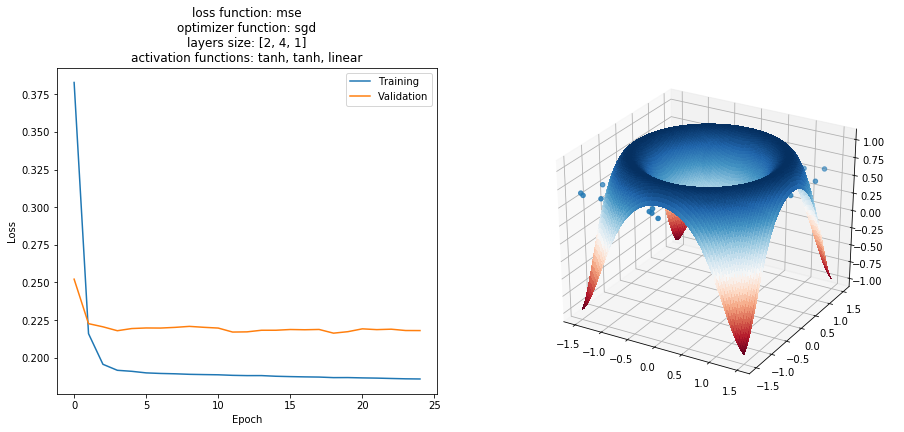

In [10]:
# Plot training info and compare predictions to target data.
fig = plt.figure(figsize = (15, 6))

def target_fn_alt(x, y):
    # Enable target_fn to work with meshgrids.
    return target_fn([x, y])

for i, (model, history) in enumerate(zip(models, model_histories)):
    # Validation results
    ax = fig.add_subplot(121)
    ax.plot(history.history["loss"])
    ax.plot(history.history["val_loss"])
    ax.set_title(
        "loss function: " + model.loss_fn
        + "\noptimizer function: " + model.optimizer_fn
        + "\nlayers size: " + str(model.layers_size)
        + "\nactivation functions: " + ", ".join(model.activation_functions)
    )
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend(["Training", "Validation"], loc = "best")
    
    # Prediction
    ax = fig.add_subplot(122, projection = "3d")
    out_predicted = model.network.predict(in_target)
    x = [pt[0] for pt in in_target]
    y = [pt[1] for pt in in_target]
    X, Y = np.meshgrid(
        np.linspace(x_min, x_max, 100),
        np.linspace(y_min, y_max, 100)
    )
    surf = ax.plot_surface(
        X, Y,
        target_fn_alt(X, Y),
        rstride = 1,
        cstride = 1, 
        cmap = plt.cm.RdBu,
        linewidth = 0,
        antialiased = False
    )
    ax.scatter(x, y, out_predicted)
'''
I'll keep it here, in case I figure it out how to make it work
with three-dimensional plots too.

n_plot_types = 2
fig, axes = plt.subplots(nrows = len(models), ncols = n_plot_types, figsize = (12, len(models) * 5))
axes = axes.flatten()


for i, (model, history) in enumerate(zip(models, model_histories)):
    # Validation results
    axes[n_plot_types * i].plot(history.history["loss"])
    axes[n_plot_types * i].plot(history.history["val_loss"])
    axes[n_plot_types * i].set_title(
        "loss function: " + model.loss_fn
        + "\noptimizer function: " + model.optimizer_fn
        + "\nlayers size: " + str(model.layers_size)
        + "\nactivation functions: " + ", ".join(model.activation_functions)
    )
    axes[n_plot_types * i].set_ylabel("Loss")
    axes[n_plot_types * i].set_xlabel("Epoch")
    axes[n_plot_types * i].legend(["Training", "Validation"], loc = "best")
    
    # Prediction
    out_predicted = model.network.predict(in_target)
    axes[n_plot_types * i + 1].scatter(in_target, out_predicted, color = "red", s = 4)
    axes[n_plot_types * i + 1].plot(in_target, out_target)
    axes[n_plot_types * i + 1].legend(["Target", "Prediction"], loc = "best")
    axes[n_plot_types * i + 1].grid(True)

fig.tight_layout()
'''
plt.show()

###### Comments

In [8]:
[target_fn(x) for x in in_training]

[0.09892346938653687,
 0.5349902799671298,
 0.10013406096674844,
 0.39897264734773136,
 0.9382406598302127,
 0.9965656389155754,
 0.03867792535136638,
 -0.22046733400813132,
 0.49966633793152954,
 0.9195465300757159,
 0.735849478089425,
 0.9844498652691586,
 0.43307959298027604,
 0.9970930555952836,
 -0.5479381479058828,
 0.9994332202227791,
 0.8766617796184025,
 0.9998681891004648,
 0.6940161431269052,
 0.9716793526788815,
 0.4366404953549302,
 0.8052782666676537,
 0.18768417739467902,
 0.5831715930621278,
 0.905783165250326,
 0.9545960582182792,
 0.910956900273408,
 0.4537500344070437,
 0.7985011439536923,
 0.9640746893226508,
 0.48489114722444565,
 0.7074357243158296,
 0.9759974996301795,
 0.9144096096164221,
 0.584561344676155,
 0.3212624589986799,
 0.6099845579423953,
 0.5800619997687575,
 0.1189117140545416,
 0.29888354769115294,
 0.9716933695389827,
 0.33157602090215327,
 0.47592333096623307,
 0.8045949706306074,
 0.7542061265817827,
 0.30125595311809966,
 0.8210120044047932,
 0